In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import math
import random
from sklearn.cluster import DBSCAN
from mlxtend.frequent_patterns import apriori, association_rules 
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import DistanceMetric
from math import radians

## Đọc file dữ liệu

Tệp dữ liệu là tệp data_pre.csv chứa các thông tin liên quan đến các xe và lộ trình thời gian và không gian của chúng trong một khoảng thời gian tại một khu vực

In [2]:
df_vehicle = pd.read_csv("data_pre.csv")

In [4]:
df_vehicle.dtypes

vehicle              object
level_1               int64
datetime             object
speed               float64
y                   float64
x                   float64
heading             float64
vehicleType           int64
time_interval       float64
distance            float64
heading_interval    float64
dtype: object

In [5]:
df_vehicle['datetime'] = pd.to_datetime(df_vehicle['datetime'])

In [6]:
df_vehicle.dtypes

vehicle                     object
level_1                      int64
datetime            datetime64[ns]
speed                      float64
y                          float64
x                          float64
heading                    float64
vehicleType                  int64
time_interval              float64
distance                   float64
heading_interval           float64
dtype: object

In [7]:
df = df_vehicle.set_index('datetime')

### Tách tổng thời gian của các xe thành các cụm 300s

In [ ]:
groupedby_minute = df.groupby(pd.Grouper(freq='300s')).count()

<AxesSubplot:xlabel='datetime'>

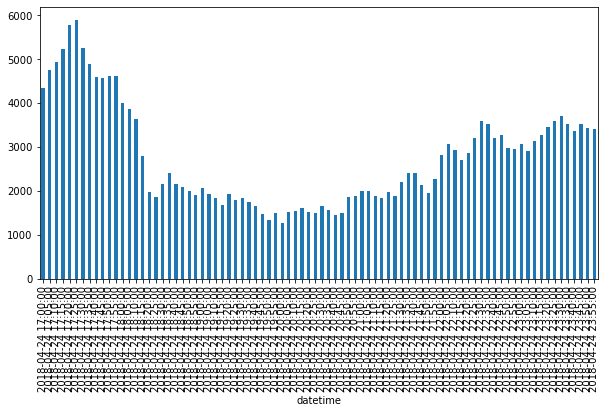

In [9]:
groupedby_minute['vehicle'].plot(kind='bar',figsize=(10,5))

### Hàm tính khoảng cách giữa 2 tọa độ di chuyển của các xe

In [10]:
def Distance(p1, p2):

    # GEPoint2D p1, GEPoint2D p2

    if p1.x == p2.x and p1.y == p2.y:
        return 0

    dbLat1InRad = p1.y * (math.pi / 180.0)
    dbLong1InRad = p1.x * (math.pi / 180.0)
    dbLat2InRad = p2.y * (math.pi / 180.0)
    dbLong2InRad = p2.x * (math.pi / 180.0)

    dbTheta = p1.x - p2.x
    dbThetaInRad = dbTheta * (math.pi / 180.0)

    a = math.sin(dbLat1InRad)
    b = math.sin(dbLat2InRad)
    c = math.cos(dbLat1InRad)
    d = math.cos(dbLat2InRad)
    e = math.cos(dbThetaInRad)
    f = a * b + c * d * e

    if f > 1:
        f = 1
    if f < -1:
        f = -1

    dbDistInRad = math.acos(f)
    dbDist = dbDistInRad * 180.0 / math.pi
    dbDist = dbDist * 60.0 * 1.1515
    dbDist = dbDist * 1.609344 * 1000

    return dbDist

### Hàm tạo ma trận khoảng cách giữa tất cả các tọa độ xuất hiện của các xe

In [11]:
def distance_matrix(df):
    dist = DistanceMetric.get_metric('haversine')
    new_df = df.copy()
    new_df['x'] = np.radians(new_df['x'])
    new_df['y'] = np.radians(new_df['y'])
    dm1 = dist.pairwise(new_df[['y','x']].to_numpy())*6373
    dm1 = dm1*1000
    return dm1.tolist()

In [12]:
len(df_vehicle['vehicle'].unique())

5856

### Chia khung thời gian trong toàn bộ thời gian của dữ liệu thành 3 phần để so sánh

In [13]:
df = df.sort_index()

In [ ]:
df1 = df.loc[:'2018-04-24 18:15:00']

In [16]:
df2 = df.loc['2018-04-24 18:15:00':'2018-04-24 21:00:00']

In [ ]:
df2

In [18]:
df3 = df.loc['2018-04-24 21:00:00':]

### Hàm thực hiện thuật toán DBSCAN

In [20]:
def DBScan_time_distance_df(df,start_time,end_time, step, eps):
    '''
    df: du lieu truyen vao
    start_time: thoi gian bat dau tinh bang giay ke tu moc thoi gian gan nhat cua df
    end_time: thoi gian ket thuc tinh bang giay ke tu moc thoi gian gan nhat cua df
    step: buoc thoi gian moi lan gom cum (s)
    eps: khoang cach gom cum
    '''
    
    
    index_start = int(start_time / step) # so thu tu cua thoi gian bat dau sau khi df da tach ra cac khoang thoi gian 20s
    index_end = int(end_time / step) # so thu tu cua thoi gian ket thuc sau khi df da tach ra cac khoanng thoi gian 20s
    if end_time == -1:
        index_end = int((df['datetime'].max() - df['datetime'].min()).seconds /step)
        
    new_df = df.copy()
    groupedby_minute = new_df.groupby(pd.Grouper(freq= str(step)+'s'))    # Chia df ra cac khoảng thời gian 20s
    list_minutes = list(groupedby_minute.groups.keys()) # List các thời gian ban đầu cách nhau 20s
    list_groupby_minutes = [groupedby_minute.get_group(time) for time in list_minutes] # List các dataframe con của df ứng với 20s
    
    # Neu index_start nho hon 0 chuyen ve 0
    if index_start<0:
        index_start = 0
    # Neu index_end lon hơn số khoảng 20s chuyển về số khoảng đó
    if index_end > len(list_minutes):
        index_end = len(list_minutes)
    if index_start > index_end:
        index_start = index_end
    list_df_cluster = []
    if index_start==index_end:
        for index,df_20 in enumerate(list_groupby_minutes[index_start:]):
            print(index,type(df_20))
            # Lập ma trận khoảng cách giữa các điểm
            distanceMatrix = distance_matrix(df_20)
            
            # Sử dụng dbscan để phân cụm các xe
            model = DBSCAN(eps=eps, min_samples=2,metric='precomputed').fit(distanceMatrix)
            
            df_20['CLUSTER_DBSCAN'] = model.labels_
            df_20 = df_20[df_20['CLUSTER_DBSCAN']> -1]
            class_predictions = [str(index)+'_'+str(index_start + item)  for item in df_20['CLUSTER_DBSCAN']]
            df_20['CLUSTER_DBSCAN'] = class_predictions
            list_df_cluster.append(df_20)
    else:
        for index,df_20 in enumerate(list_groupby_minutes[index_start:index_end]):
            print(index,len(df_20))
            # Lập ma trận khoảng cách giữa các điểm
            distanceMatrix = distance_matrix(df_20.reset_index())
            # Sử dụng dbscan để phân cụm các điểm
            model = DBSCAN(eps=eps, min_samples=2,metric='precomputed').fit(distanceMatrix)
            df_20['CLUSTER_DBSCAN'] = model.labels_
            df_20 = df_20[df_20['CLUSTER_DBSCAN']> -1]
            class_predictions = [str(index)+'_'+str(index_start + item)  for item in df_20['CLUSTER_DBSCAN']]
            df_20['CLUSTER_DBSCAN'] = class_predictions
            list_df_cluster.append(df_20)
    return pd.concat(list_df_cluster)

In [21]:
%%time
df1_with_cluster = DBScan_time_distance_df(df1,0,4500,20,50)

0 238
1 272
2 267
3 268
4 273
5 300
6 251
7 279
8 293
9 283
10 314
11 339
12 323
13 307
14 327
15 330
16 289
17 325
18 294
19 305
20 309
21 336
22 356
23 336
24 300
25 323
26 331
27 327
28 278
29 313
30 329
31 322
32 326
33 333
34 302
35 305
36 326
37 343
38 334
39 351
40 342
41 349
42 322
43 305
44 350
45 356
46 345
47 352
48 328
49 350
50 343
51 330
52 342
53 340
54 365
55 394
56 336
57 336
58 369
59 346
60 354
61 350
62 383
63 369
64 360
65 335
66 366
67 403
68 399
69 396
70 417
71 431
72 385
73 414
74 428
75 417
76 410
77 410
78 376
79 395
80 399
81 394
82 426
83 391
84 400
85 367
86 375
87 401
88 366
89 371
90 364
91 354
92 386
93 360
94 338
95 360
96 360
97 335
98 368
99 344
100 331
101 355
102 331
103 335
104 328
105 329
106 333
107 343
108 316
109 333
110 328
111 323
112 326
113 352
114 339
115 324
116 319
117 330
118 306
119 287
120 303
121 308
122 315
123 326
124 319
125 283
126 318
127 334
128 305
129 305
130 305
131 286
132 297
133 305
134 286
135 321
136 320
137 289
138 30

In [23]:
df1_with_cluster.to_csv('df1_1700_1815.csv')

In [24]:
%%time
df2_with_cluster = DBScan_time_distance_df(df2,0,9900,20,50)

0 231
1 200
2 202
3 186
4 196
5 195
6 189
7 208
8 211
9 157
10 175
11 170
12 150
13 164
14 156
15 153
16 138
17 151
18 139
19 137
20 122
21 128
22 145
23 148
24 116
25 137
26 121
27 112
28 116
29 109
30 114
31 112
32 130
33 117
34 118
35 130
36 117
37 108
38 120
39 111
40 126
41 131
42 120
43 152
44 147
45 131
46 140
47 139
48 144
49 144
50 140
51 136
52 130
53 158
54 138
55 150
56 145
57 144
58 156
59 151
60 152
61 154
62 148
63 150
64 169
65 178
66 181
67 165
68 158
69 173
70 142
71 152
72 173
73 164
74 158
75 152
76 151
77 175
78 144
79 137
80 140
81 153
82 141
83 146
84 154
85 130
86 140
87 122
88 137
89 134
90 144
91 123
92 136
93 135
94 138
95 162
96 152
97 145
98 136
99 137
100 136
101 139
102 147
103 130
104 124
105 123
106 124
107 129
108 120
109 138
110 130
111 147
112 137
113 126
114 142
115 144
116 134
117 140
118 123
119 138
120 114
121 128
122 129
123 113
124 134
125 141
126 123
127 149
128 127
129 138
130 115
131 124
132 115
133 137
134 117
135 120
136 134
137 153
138 14

In [ ]:
%%time
df3_with_cluster = DBScan_time_distance_df(df3,0,10800,20,50)

### Hàm thực hiện tìm các cụm của mỗi xe

In [26]:
%%time
def vehicle_together(data):
    list_vehicle = data['vehicle'].unique()
    cluster_ID = {}
    for vehicle in list_vehicle:
        cluster_ID[vehicle] = data[data['vehicle'] == vehicle]['CLUSTER_DBSCAN'].unique() 
#     cluster_ID = [data[data['vehicle'] == i]['CLUSTER_DBSCAN'].unique() for i in list_vehicle]
    
    return cluster_ID

list_vehicle_cluster_1 = vehicle_together(df1_with_cluster)
list_vehicle_cluster_2 = vehicle_together(df2_with_cluster)
list_vehicle_cluster_3 = vehicle_together(df3_with_cluster)

Wall time: 23.7 s


In [ ]:
list_vehicle_cluster_1

In [28]:
%%time
df3_with_cluster.to_csv('df_cluster_2100.csv')

Wall time: 678 ms


In [30]:
%%time
df1_with_cluster.to_csv("df2_1815_2100.csv")

Wall time: 576 ms


### Hàm thực hiện chuẩn bị dữ liệu cho Thuật toán Apriori bằng phương pháp tạo ma trận của các xe với toàn bộ các cụm

In [31]:
def apyori_data(data):
    list_vehicle_cluster = vehicle_together(data)
    matrix_vehicle = {}
    for vehicle in data['vehicle'].unique():
        matrix_vehicle[vehicle] = []
    for vehicle in data['vehicle'].unique():
        for cluster in data['CLUSTER_DBSCAN'].unique():
            matrix_vehicle[vehicle].append(cluster in list_vehicle_cluster[vehicle])
#             if cluster not in list_vehicle_cluster[vehicle]:
#                 matrix_vehicle[vehicle].append(False)
#             else:
#                 matrix_vehicle[vehicle].append(True)
    df_vehicle = pd.DataFrame.from_dict(matrix_vehicle, orient='index')
    df_vehicle.columns = data['CLUSTER_DBSCAN'].unique()
    return df_vehicle

In [32]:
%%time
df_vehicle_1700_1815 = apyori_data(df1_with_cluster)
df_vehicle_1700_1815.to_csv('df_cluster_vehicle_1700_1815.csv')
df_vehicle_1815_2100 = apyori_data(df2_with_cluster)
df_vehicle_1815_2100.to_csv('df_cluster_vehicle_1815_2100.csv')


Wall time: 3min 58s


In [33]:
%%time
df_vehicle_2100 = apyori_data(df3_with_cluster)
df_vehicle_2100.to_csv('df_cluster_vehicle_2100.csv')

Wall time: 6min 57s


### Thực hiện thuật toán Apriori

In [ ]:
%%time
df_together_1 = apriori(df_vehicle_1700_1815.T, min_support=0.001, use_colnames=True,verbose=1) # 0.0008: 813 |


In [ ]:
%%time
df_together_2 = apriori(df_vehicle_1815_2100.T, min_support=0.001, use_colnames=True,verbose=1) # 0.0008: 813 |


In [ ]:
%%time
df_together_3 = apriori(df_vehicle_1815_2100.T, min_support=0.001, use_colnames=True,verbose=1) # 0.0008: 813 |


In [37]:
# df_together_2.to_csv("df_together_2_1815_2100_001.csv")

In [38]:
# df_together_1.to_csv("df_together_1_1700_1815_001.csv")

In [39]:
# df_together_3.to_csv("df_together_3_2100_001.csv")

In [ ]:
df1

In [41]:
df_together = pd.concat([df_together_1,df_together_2,df_together_3])

In [42]:
len(df_together['itemsets'].unique())

1910

In [43]:
df_together.drop_duplicates(subset ="itemsets", inplace = True)

### Cuối cùng ta tìm được các xe đi cùng nhau

In [44]:
df_together['itemsets'] = df_together['itemsets'].apply(lambda x: list(x))

In [45]:
df_together_02 = df_together[df_together['itemsets'].apply(len)==2]

In [ ]:
df_together_02

In [47]:
df_vehicle = pd.read_csv("data_pre.csv")

In [54]:
%%time
df_vehicle['label'] = 0

# list_vehicle = list(set(df_vehicle.vehicle))
# labels = random.sample(range(len(list_vehicle)+1), len(list_vehicle))
# dict_label_vehicle = {}
# for vehicle_id in range(len(list_vehicle)):
#     for x in df_vehicle[df_vehicle['vehicle']==list_vehicle[vehicle_id]].index:
#         df_vehicle.at[x,'label'] = labels[vehicle_id]
#         dict_label_vehicle[list_vehicle[vehicle_id]] = labels[vehicle_id]

Wall time: 1.5 ms


In [61]:
%%time
for list_vehicle_together in df_together_02['itemsets']:
    for vehicle in list_vehicle_together:
        df_vehicle.loc[(df_vehicle['vehicle']==vehicle),'label']= 1

Wall time: 6.93 s


In [ ]:
df_vehicle

In [ ]:
df_vehicle[df_vehicle['label']==1]

In [ ]:
df_vehicle[df_vehicle['label']==1]['vehicle'].unique()

In [56]:
# %%time
# dict_vehicle = {}
# for list_vehicle_together in df_together_02['itemsets']:
#     for vehicle in list_vehicle_together:
#         dict_vehicle[vehicle] = 0
# for list_vehicle_together in df_together_02['itemsets']:
#     vehicle_0 = list_vehicle_together[0]
#     vehicle_1 = list_vehicle_together[1]
#     print(vehicle_0,',',vehicle_1)
#     if dict_vehicle[vehicle_0] == 0 and dict_vehicle[vehicle_1] == 0:
#         print(dict_vehicle[vehicle_0])
#         df_vehicle.loc[(df_vehicle['vehicle'] == vehicle_0),'label']= dict_label_vehicle[vehicle_1]
#     elif dict_vehicle[vehicle_0] == 1 and dict_vehicle[vehicle_1] == 0:
#         df_vehicle.loc[(df_vehicle['vehicle'] == vehicle_1),'label']= dict_label_vehicle[vehicle_0]
#     elif dict_vehicle[vehicle_0] == 0 and dict_vehicle[vehicle_1] == 1:
#         df_vehicle.loc[(df_vehicle['vehicle'] == vehicle_0),'label'] = dict_label_vehicle[vehicle_1]
#     dict_vehicle[vehicle_0] = 1
#     dict_vehicle[vehicle_1] = 1

In [50]:
len(df_vehicle.label.unique())

5707

In [51]:
len(df_vehicle.vehicle.unique())

5856

In [52]:
df_together_02.to_csv('df_together_02.csv')

In [63]:
%%time
df_vehicle.to_csv('data_train_22032021.csv')

Wall time: 2.23 s
